In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import math
import random

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20
plt.rcParams["axes.grid"] =True

from sklearn.linear_model import LinearRegression

# Map

In [2]:
class Map:
    
    color_map = None
    policy = None
    pos_to_coord = None
    coord_to_pos = None
    
    def __init__(self, path_to_map, path_to_policy=None, calib_coord=None, calib_bmp=None):
        self.color_map = cv.imread(path_to_map)
        self.color_map = cv.cvtColor(self.color_map, cv.COLOR_BGR2RGB)
        if path_to_policy is None:
            self.policy = np.ones(shape=self.map.shape())*255
        else:
            self.policy = cv.imread(path_to_policy,cv.IMREAD_GRAYSCALE)
        if calib_coord is not None and calib_bmp is not None:
            self.calibrate(calib_coord, calib_bmp)
        pass
    
    
    def calibrate(self, calib_coord, calib_bmp):
        self.coord_to_pos = LinearRegression()
        self.coord_to_pos.fit(calib_coord,calib_bmp)
        self.pos_to_coord = LinearRegression()
        self.pos_to_coord.fit(calib_bmp,calib_coord)
    
    
    def to_coord(self, bmp_pos):
        if self.pos_to_coord is not None:
            return self.pos_to_coord.predict(bmp_pos)
        else:
            return None
    
    
    def to_pos(self, coord):
        if self.coord_to_pos is not None:
            return np.round(self.coord_to_pos.predict(coord)).astype(int)
        else:
            return None
    
    def plot(self, coord=None, file=None):
        plot_map = self.color_map.copy()
        if coord is not None:
            pos = self.to_pos(coord)
            if pos is not None:
                for point in pos:
                    cv.circle(plot_map, (point[1], point[0]), radius=1, color=(255,0,0), thickness=-1)
        fig = plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(plot_map)
        plt.show()
        if file is not None:
            fig.savefig(file, bbox_inches='tight')
        
    
    def plot_policy(self):
        plt.figure(figsize=(40,20))
        plt.grid(False)
        plt.imshow(self.policy)
        plt.show()
        
    def get_shape(self):
        return self.policy.shape[0:2]
    
    def get_policy_prob_pos (self,pos):
        prob = np.zeros(len(pos))
        for i,point in enumerate(pos):
            if ((point[0]<0) or (point[0]>=self.policy.shape[0]) or (point[1]<0) or (point[1]>=self.policy.shape[1])):
                prob[i] = self.policy[0,0] * 0
            else:
                prob[i] = self.policy[point[0],point[1]] / 255
        return prob
    
    def get_policy_prob (self,coords):
        points = self.to_pos(coords)
        prob = np.zeros(points.shape[0])
        for i,point in enumerate(points):
            if ((point[0]<0) or (point[0]>=self.policy.shape[0]) or (point[1]<0) or (point[1]>=self.policy.shape[1])):
                prob[i] = self.policy[0,0] * 0
            else:
                prob[i] = self.policy[point[0],point[1]] / 255
        
        return prob
    
    @staticmethod
    def destinationPoint(lat, lon, distance, bearing):
        '''
        Returns the destination point from a given point, having travelled the given distance
        on the given initial bearing.

        @param   {number} lat - initial latitude in decimal degrees (eg. 50.123)
        @param   {number} lon - initial longitude in decimal degrees (e.g. -4.321)
        @param   {number} distance - Distance travelled (metres).
        @param   {number} bearing - Initial bearing (in degrees from north).
        @returns {array} destination point as [latitude,longitude] (e.g. [50.123, -4.321])

        @example
        var p = destinationPoint(51.4778, -0.0015, 7794, 300.7); // 51.5135°N, 000.0983°W
        '''
        radius = 6371e3; # (Mean) radius of earth
        
        def toRadians(v):
            return v * math.pi / 180
        
        def toDegrees(v):
            return v * 180 / math.pi


        delta = distance / radius; # angular distance in radians
        theta = toRadians(bearing);

        phi_1 = toRadians(lat);
        lambda_1 = toRadians(lon);
        
        sin_phi_1 = math.sin(phi_1) 
        cos_phi_1 = math.cos(phi_1)
        sin_delta = math.sin(delta)
        cos_delta = math.cos(delta)
        sin_theta = math.sin(theta)
        cos_theta = math.cos(theta)

        sin_phi_2 = sin_phi_1* cos_delta + cos_phi_1 * sin_delta * cos_theta
        phi_2 = math.asin(sin_phi_2)
        y = sin_theta * sin_delta * cos_phi_1
        x = cos_delta - sin_phi_1 * sin_phi_2
        lambda_2 = lambda_1 + math.atan2(y, x)
        
        lat2 = toDegrees(phi_2)
        
        lon2 = (toDegrees(lambda_2) + 540) % 360 - 180 # normalise to −180..+180°

        return lat2,lon2
    
    @staticmethod
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance in meters between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1 = math.radians (lon1)
        lat1 = math.radians (lat1)
        lon2 =  math.radians (lon2)
        lat2 =  math.radians (lat2)

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a)) 
        r = 6371 * 1000 # Radius of earth in meters.
        return c * r 
    
    @staticmethod
    def get_bearing(lat1, long1, lat2, long2):
        dLon = (long2 - long1)
        x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
        y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
        brng = np.arctan2(x,y)
        brng = np.degrees(brng)

        return brng

In [3]:
rosario_map_path = 'map/raw.png'
rosario_policy_path = 'map/Rosario_compress_blur.bmp'
calib_coord = [[ -32.95907 , -60.63112],[ -32.9486 , -60.71226],[ -32.87341 , -60.69889],[ -32.92526 , -60.66143]]
calib_bmp = [[ 1370 , 1258],[ 1212 , 215],[ 56, 386],[ 853, 867]]

work_map = Map(rosario_map_path,rosario_policy_path, calib_coord, calib_bmp)

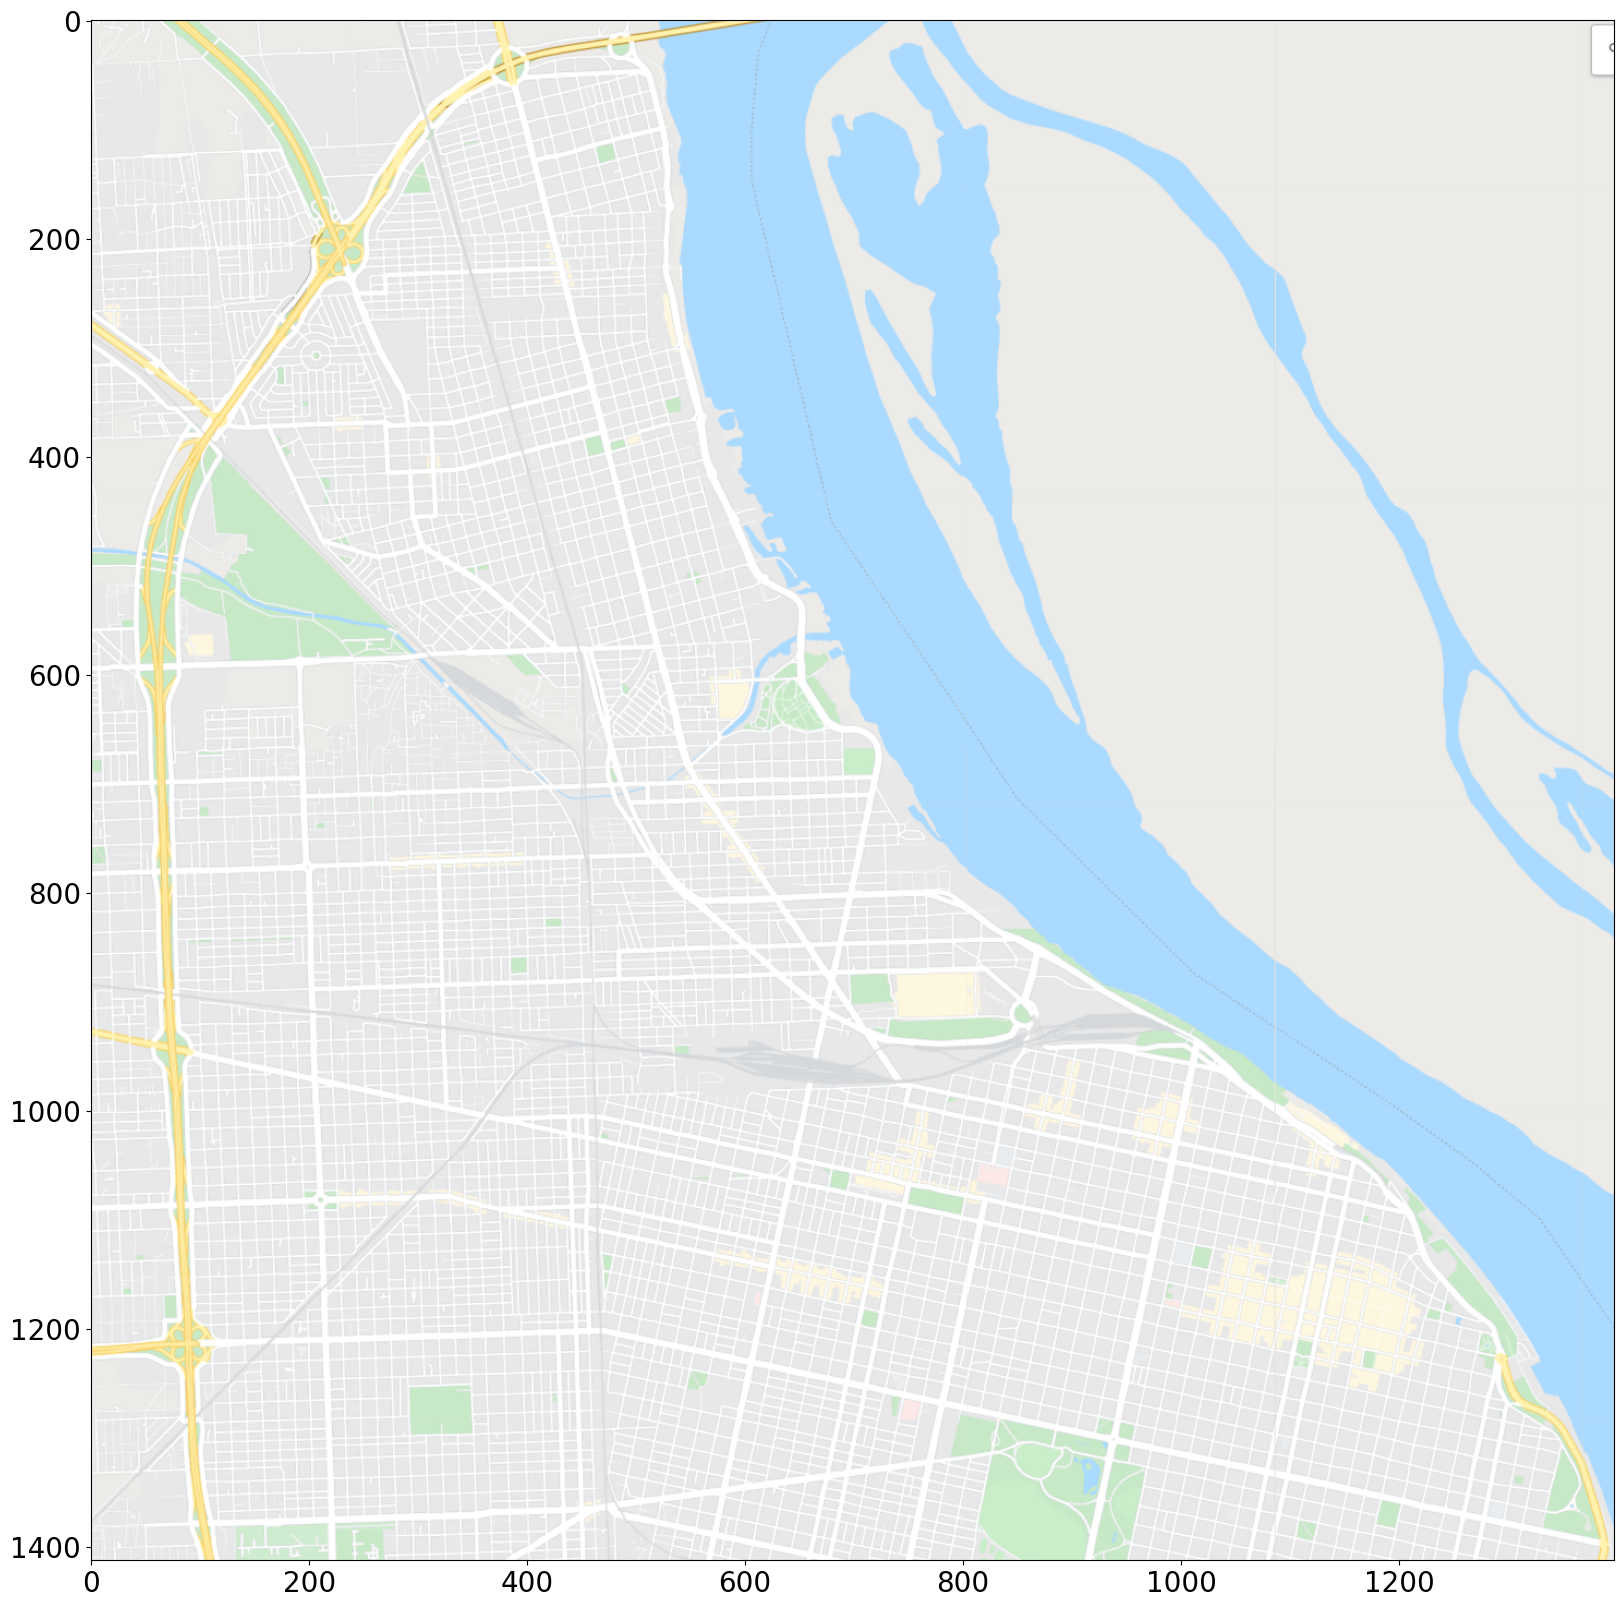

In [4]:
work_map.plot()

# Path Data

In [5]:
route_path = "data/SensorTracker.csv"
route = pd.read_csv(route_path, sep=",")

In [6]:
route.head()

Unnamed: 0     Timestamp  Accel_x  Accel_y  Accel_z  Gyro_x  Gyro_y  \
0           0  1.633986e+09   -0.348   -1.021    9.815  -0.003  -0.013   
1           1  1.633986e+09    0.049   -0.755   10.256  -0.005   0.028   
2           2  1.633986e+09   -0.499   -1.013    9.925  -0.023  -0.014   
3           3  1.633986e+09   -0.447   -0.975   10.309  -0.008  -0.013   
4           4  1.633986e+09   -0.504   -0.999    9.621  -0.008  -0.003   

   Gyro_z  Light  Magnetic_x  Magnetic_y  Magnetic_z  Proximity  Latitude  \
0   0.004  410.5     -47.831      18.263     -58.669        5.0 -32.95812   
1  -0.001  410.5     -48.469      15.900     -60.525        5.0 -32.95813   
2  -0.005  410.5     -48.975      18.281     -59.419        5.0 -32.95815   
3   0.019  372.5     -48.788      16.856     -58.800        5.0 -32.95816   
4   0.012  372.5     -50.456      19.406     -60.488        5.0 -32.95818   

   Longitude  Elevation     Speed  Acceleration    Bearing  
0  -60.63654       52.8  8.083333        -1.021  86.323690  
1  -60.63644       53.6  8.361111        -0.755  61.604633  
2  -60.63635       51.9  8.361111        -1.013  30.706606  
3  -60.63627       51.2  8.111111        -0.975  82.547460  
4  -60.63618       50.6  7.750000        -0.999  88.920540

# Particle

In [117]:
class Particle():
    
    def __init__(self, init_pos, speed, bearing):
        self.pos = init_pos
        self.pos_history = [init_pos]
        self.fitness_history = []
        self.speed = speed
        self.bearing = bearing
        self.last_distance = 0.0
        self.last_speed = 0.0
        self.last_bearing = 0.0
        self.cum_distance = 0.0
        self.c1 = 0.2
        self.c2 = 0.2

    def move(self, timestep=1):
        if self.speed is not None and len(self.speed)>0 and self.bearing is not None and len(self.bearing)>0:
            self.last_speed = self.speed.pop(0)
            self.last_bearing = self.bearing.pop(0)
            self.last_distance = self.last_speed  * timestep
            self.cum_distance = self.cum_distance + self.last_distance
            self.pos = Map.destinationPoint(self.pos[0], self.pos[1], self.last_distance, self.last_bearing)

    def save_pos(self):
        self.pos_history.append(self.pos)
        self.fitness_history.append(work_map.get_policy_prob([self.pos])[0])

    def is_finished(self):
        return self.speed is None or len(self.speed) == 0 or self.bearing is None or len(self.bearing) == 0

    def reset_cumulative_distance(self):
        self.cum_distance = 0.0

    def get_cumulative_distance(self):
        return self.cum_distance

    def pso_start(self):
        self.best_pso_fitness = -1
        self.pso_evaluate()
        self.last_speed = 0
        self.last_bearing = 0

    def pso_evaluate(self):
        self.last_pso_fitness = work_map.get_policy_prob([self.pos])[0]
        if self.last_pso_fitness > self.best_pso_fitness:
            self.best_pso_fitness = self.last_pso_fitness
            self.pbest = self.pos

    def pso_move(self, top_particles, cluster_distance, timestep = 1):
        lbest = None
        new_pos = self.pos
        for i in range(len(top_particles)):
            if Map.haversine(self.pos[0], self.pos[1], top_particles[i].pos[0], top_particles[i].pos[1]) < cluster_distance:
                lbest = top_particles[i].pos
                break
        if self.last_speed > 0:
            distance = self.last_speed * timestep
            new_pos = Map.destinationPoint(self.pos[0], self.pos[1], distance, self.last_bearing)
        if self.pbest != self.pos:
            pbest_distance = Map.haversine(new_pos[0], new_pos[1], self.pbest[0], self.pbest[1])
            pbest_bearing = Map.get_bearing(new_pos[0], new_pos[1], self.pbest[0], self.pbest[1])
            new_pos = Map.destinationPoint(new_pos[0], new_pos[1], self.c1 * pbest_distance, pbest_bearing)
        if lbest is not None and lbest != self.pos:
            lbest_distance = Map.haversine(new_pos[0], new_pos[1], lbest[0], lbest[1])
            lbest_bearing = Map.get_bearing(new_pos[0], new_pos[1], lbest[0], lbest[1])
            new_pos = Map.destinationPoint(new_pos[0], new_pos[1], self.c2 * lbest_distance, lbest_bearing)
        if new_pos != self.pos:
            self.last_speed = Map.haversine(self.pos[0], self.pos[1], new_pos[0], new_pos[1])
            self.last_bearing = Map.get_bearing(self.pos[0], self.pos[1], new_pos[0], new_pos[1])
            self.pos = new_pos

    def pso_set_pbest(self):
        self.pos = self.pbest

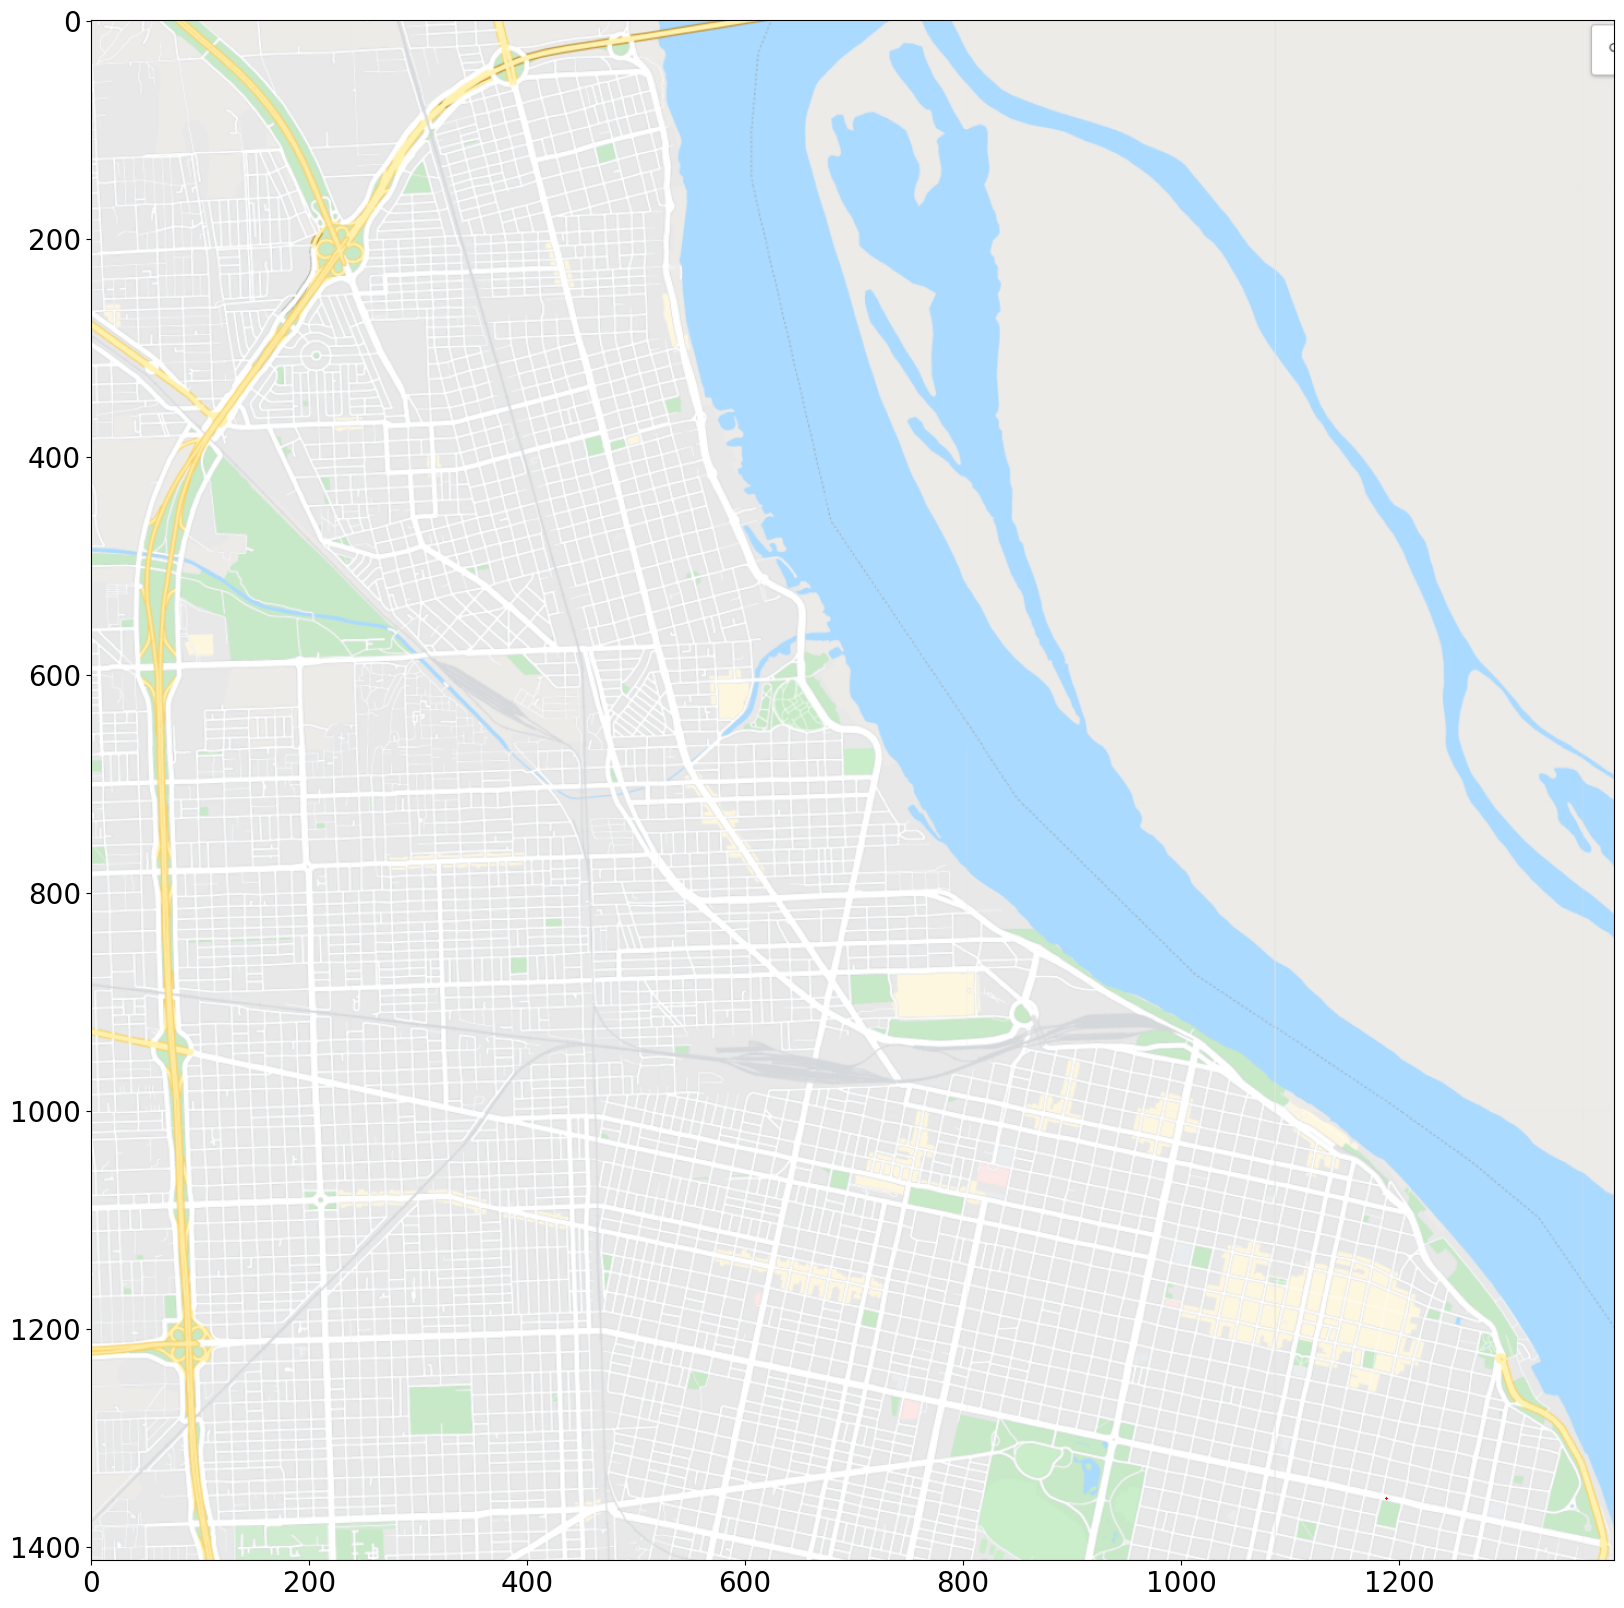

In [118]:
particle = Particle((route['Latitude'].iloc[0], route['Longitude'].iloc[0]), list(route['Speed']), list(route['Bearing']))

while not particle.is_finished():
    particle.move()

work_map.plot(particle.pos_history)

# PSO with movement

# Configuration

In [119]:
max_particles = 20000
max_move_epochs = 500
min_distance_update = 100
pso_epochs = 20
local_cluster_distance = 50
max_cluster_particles = 1000

# Initialization

In [120]:
initial_points_pos = np.argwhere(work_map.policy==255)
initial_points_coord = work_map.to_coord(initial_points_pos)
initial_points_coord

array([[-32.86975465, -60.69077   ],
       [-32.8697548 , -60.69069216],
       [-32.86975494, -60.69061433],
       ...,
       [-32.96178538, -60.6208177 ],
       [-32.96178553, -60.62073987],
       [-32.96178567, -60.62066204]])

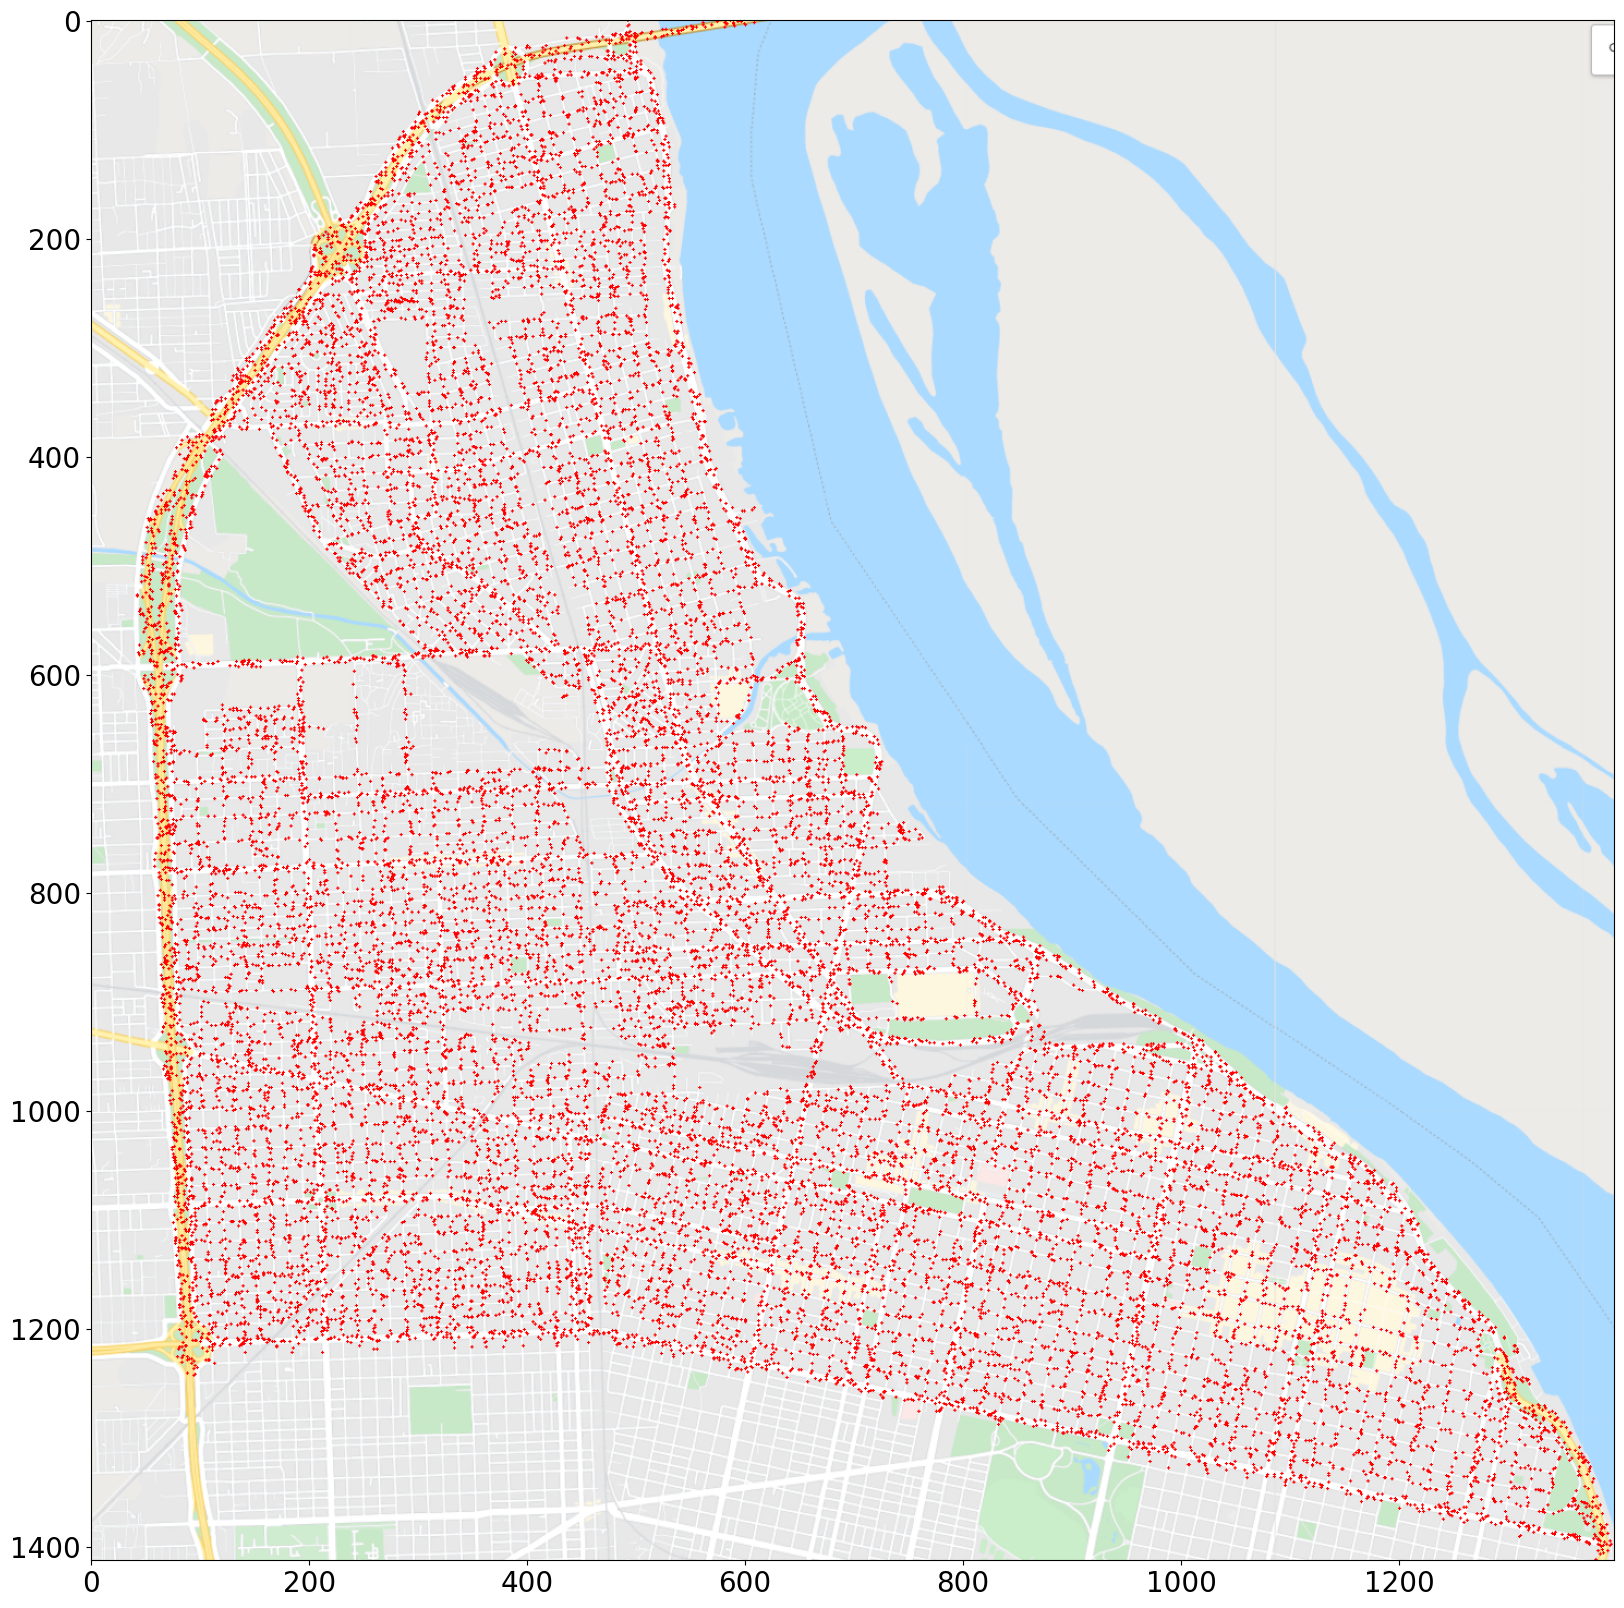

In [121]:
np.random.shuffle(initial_points_coord)
initial_points_coord = initial_points_coord[0:min(len(initial_points_coord), max_particles)]
work_map.plot(initial_points_coord)

In [122]:
population = []
speed = np.array(route['Speed'])
speed = speed[0:min(len(speed),max_move_epochs)]
bearing = np.array(route['Bearing'])
bearing = bearing[0:min(len(bearing),max_move_epochs)]

for init_coord in initial_points_coord:
    normal_noise_speed = speed + np.random.normal(0, 0.1 * abs(speed),len(speed))
    normal_noise_bearing = bearing + np.random.normal(0, 0.1 * abs(bearing),len(bearing))
    particle = Particle(init_coord, list(normal_noise_speed), list(normal_noise_bearing))
    population.append(particle)

# Evolutive Algorithm

In [125]:
# Step 1 move until cummulative distance > min_distance_update
epoch = 0
total_epochs = len(speed)

while epoch < total_epochs:
    for particle in population:
        particle.reset_cumulative_distance()
    while epoch < total_epochs and population[0].get_cumulative_distance() < min_distance_update:
        for particle in population:
            particle.move()
        epoch = epoch + 1
    
    # Step 2 PSO
    for particle in population:
        particle.pso_start()
    top_particles = [population[i] for i in np.argsort([particle.last_pso_fitness for particle in population]).tolist()[::-1][0:max_cluster_particles]]
    for _ in range(pso_epochs):
        for particle in population:
            particle.pso_move(top_particles, local_cluster_distance)
        for particle in population:
            particle.pso_evaluate()
    
    # Save best pos
    for particle in population:
        particle.pso_set_pbest()
        particle.save_pos()

KeyboardInterrupt: 

In [136]:
np.argsort([sum(particle.fitness_history) for particle in population])[-4]

np.int64(1698)

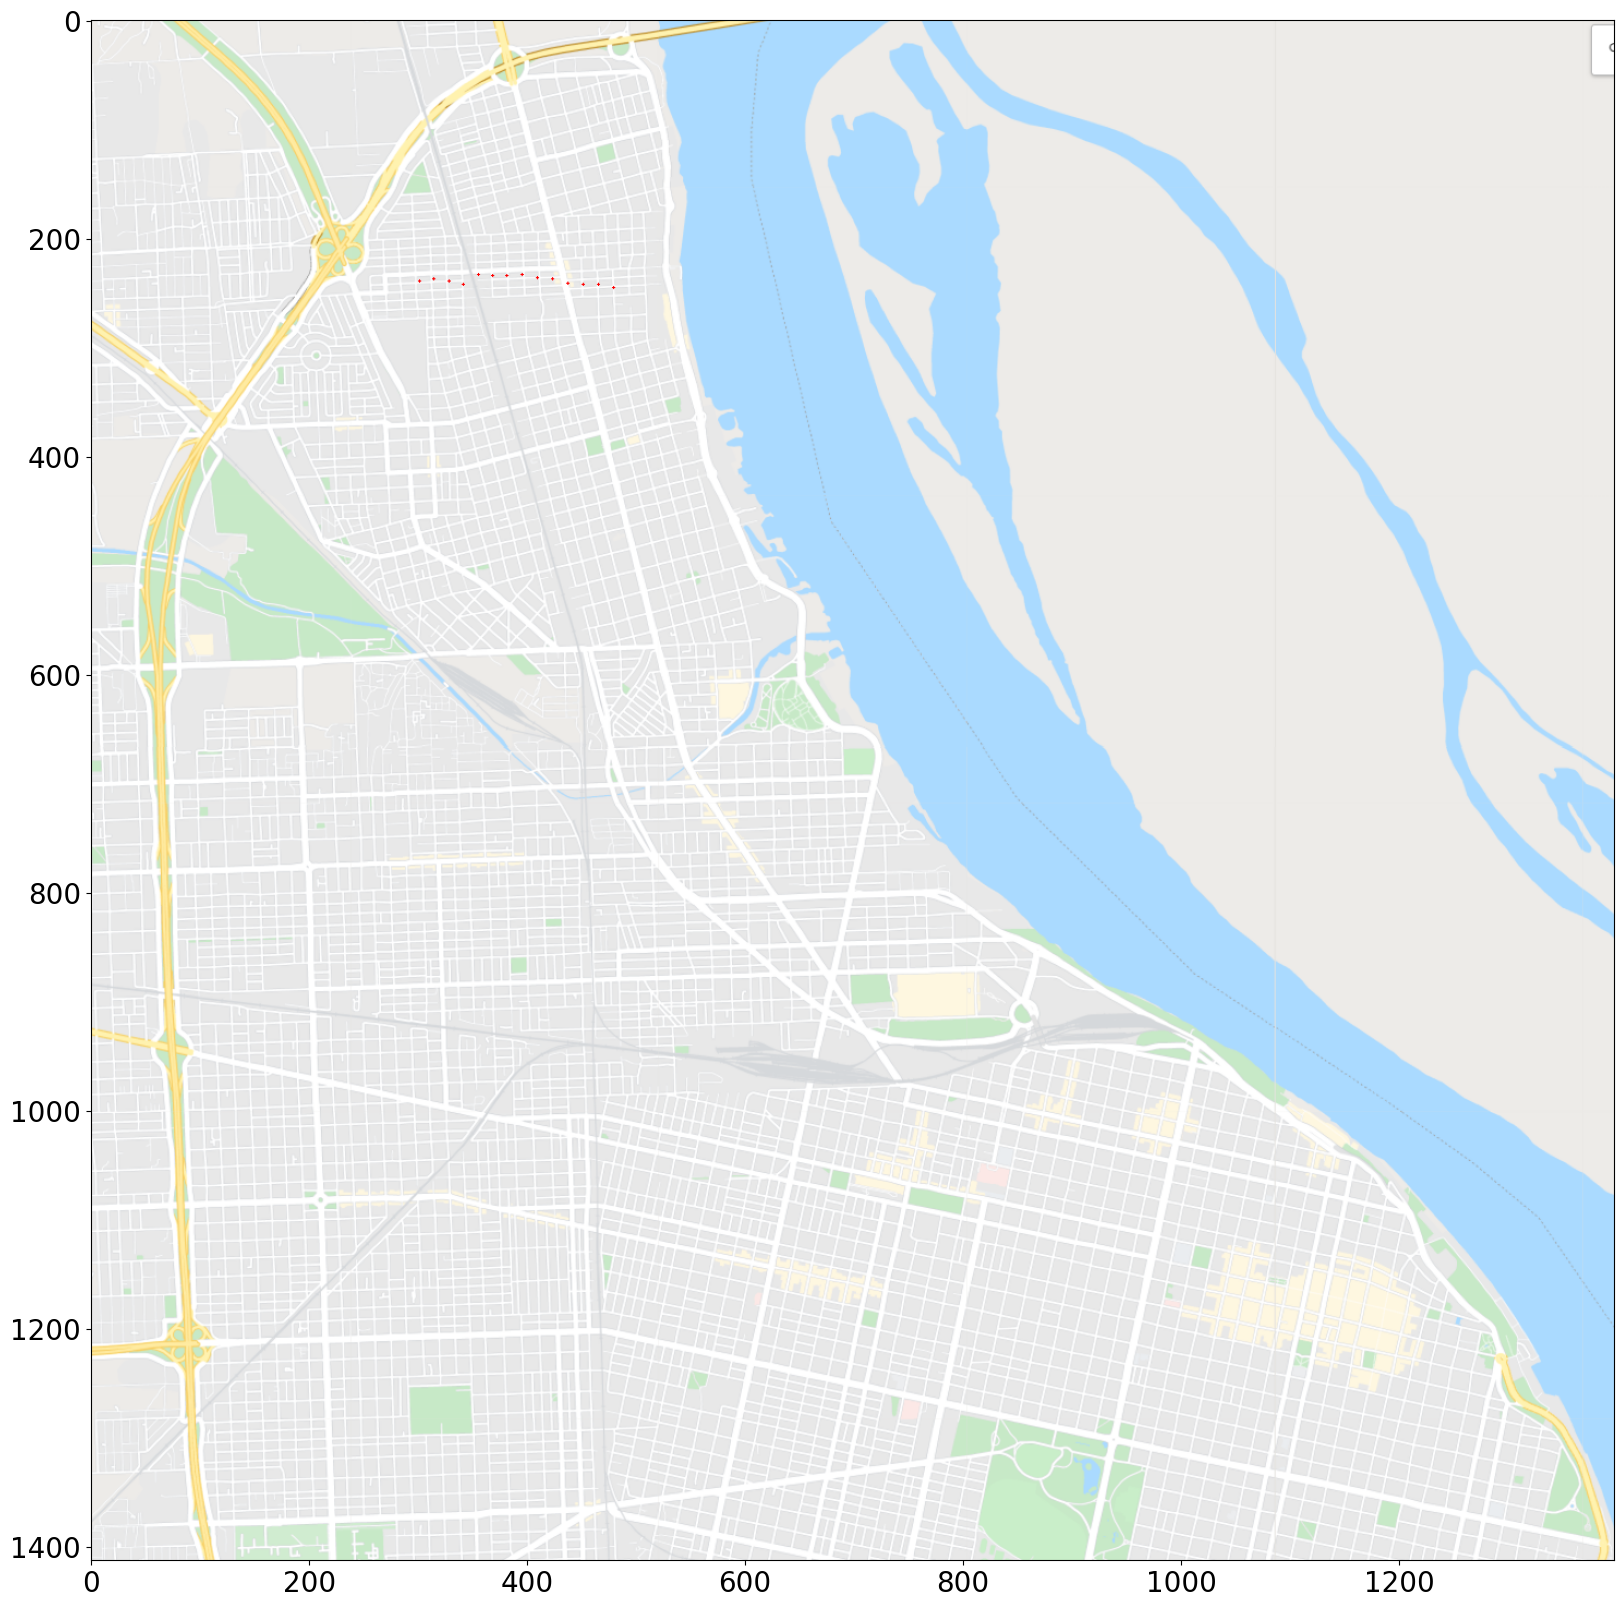

In [137]:
work_map.plot(population[1698].pos_history)